In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import numpy as np
import keras
import tensorflow as tf
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.feature import hog
from sklearn.svm import SVC

2024-01-09 22:27:19.443380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
SEED = 172024
random.seed(SEED)

In [4]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_model_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    total_samples_per_class = cm.sum(axis=1)
    accuracies_per_class = cm.diagonal() / total_samples_per_class

    class_0_accuracy = accuracies_per_class[0]
    class_1_accuracy = accuracies_per_class[1]

    metrics = (acc, prec, recall, f1, roc, class_0_accuracy, class_1_accuracy)
    return metrics

In [5]:
BASE_DIR_PATH = os.path.abspath(os.getcwd())
DATA_BASE_DIR = BASE_DIR_PATH + '/data/'

In [6]:
OG_CAR_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original'
OG_CAR_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original/Car'
OG_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/original/Bike'

CAR_BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned'
CAR_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned/Car'
BIKE_DIR = DATA_BASE_DIR + 'Car-Bike-Dataset/cleaned/Bike'

In [54]:
columns = ['id', 'pil_img', 'np_img', 'flat_img', 'hog_fd', 'hog_img', 'label']

array_hog_32 = np.load(CAR_BIKE_DIR + '/32/df_hog_32.npy', allow_pickle=True)
df_hog_32 = pd.DataFrame(array_hog_32, columns=columns)

array_hog_128 = np.load(CAR_BIKE_DIR + '/128/df_hog_128.npy', allow_pickle=True)
df_hog_128 = pd.DataFrame(array_hog_128, columns=columns)

In [8]:
df_hog_32.head(2)

,id,pil_img,np_img,flat_img,hog_fd,hog_img,label
0,0-Bike,<PIL.Image.Image image mode=RGB size=32x32 at ...,"[[[[ 0.30980396 -0.7254902 -0.7019608 ], [ 0....","[0.30980396, -0.7254902, -0.7019608, 0.3647059...","[0.03865292168975405, 0.0, 0.0, 0.0, 0.3401712...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,1-Bike,<PIL.Image.Image image mode=RGB size=32x32 at ...,"[[[[0.9764706 0.8980392 0.7411765], [0.9764706...","[0.9764706, 0.8980392, 0.7411765, 0.9764706, 0...","[0.0589068554210715, 0.0, 0.026773553866190656...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [9]:
from sklearn.model_selection import StratifiedKFold

def k_fold_scores(model, df_hog_img, model_name=None, n_splits=10, seed=172024) -> dict:

    random.seed(seed)

    rand_list = random.sample(range(0, len(df_hog_img)), len(df_hog_img))

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    k_fold_results = {}

    # Vectorized images
    randomized_imgs = []

    # shuffle records according to rand_list
    for i in range(len(df_hog_img)):
        ind = rand_list[i]
        flat_img, label = df_hog_img['flat_img'][ind], df_hog_img['label'][ind]
        randomized_imgs.append(np.array([flat_img, label], dtype=object))

    randomized_imgs = np.array(randomized_imgs)

    X, y = randomized_imgs[:, 0], randomized_imgs[:, 1]

    wide_X = np.zeros((len(X), X[0].shape[0]))
    for indx in range(len(X)):
        for feature in range(X[0].shape[0]):
            wide_X[indx][feature] = X[indx][feature]
    
    y = y.astype(int)

    # Vectorized Stratified K-Fold
    acc_scores = []
    prec_scores = []
    recall_scores = []
    f1_scores = []
    roc_scores = []
    class_0_acc_scores = []
    class_1_acc_scores = []

    for train_indx, test_indx in skf.split(wide_X, y):
        X_train, X_test = wide_X[train_indx], wide_X[test_indx]
        y_train, y_test = y[train_indx], y[test_indx]     
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc, prec, recall, f1, roc, class_0_accuracy, class_1_accuracy = get_model_scores(y_test, y_pred)
        acc_scores.append(acc); prec_scores.append(prec)
        recall_scores.append(recall); f1_scores.append(f1)
        roc_scores.append(roc); class_0_acc_scores.append(class_0_accuracy)
        class_1_acc_scores.append(class_1_accuracy)

    avg_acc = np.mean(acc_scores)
    avg_prec_scores = np.mean(prec_scores)
    avg_recall_scores = np.mean(recall_scores)
    avg_f1_scores = np.mean(f1_scores)
    avg_roc_scores = np.mean(roc_scores)
    avg_class_0_acc_scores = np.mean(class_0_acc_scores)
    avg_class_1_acc_scores = np.mean(class_1_acc_scores)

    if model_name is not None:
        print(f'(Vectorized) {model_name} Model Stratified {n_splits}-Fold Results:')
    print(f'{avg_acc=}')
    print(f'{avg_prec_scores=}')
    print(f'{avg_recall_scores=}')
    print(f'{avg_f1_scores=}')
    print(f'{avg_roc_scores=}')
    print(f'{avg_class_0_acc_scores=}')
    print(f'{avg_class_1_acc_scores=}')

    k_fold_results['flat_img_results'] = (avg_acc, avg_prec_scores, avg_recall_scores, avg_f1_scores, avg_roc_scores, avg_class_0_acc_scores, avg_class_1_acc_scores)

    # HOG
    hog_records = []

    for i in range(len(df_hog_img)):
        ind = rand_list[i]
        hog_fd, label = df_hog_img['hog_fd'][ind], df_hog_img['label'][ind]
        hog_records.append(np.array([hog_fd, label], dtype=object))

    hog_records = np.array(hog_records)

    hog_X, hog_y = hog_records[:, 0], hog_records[:, 1]

    hog_y = hog_y.astype(int)

    hog_wide_X = np.zeros((len(hog_X), hog_X[0].shape[0]))
    for indx in range(len(hog_X)):
        for feature in range(hog_X[0].shape[0]):
            hog_wide_X[indx][feature] = hog_X[indx][feature]

    # HOG Stratified K-Fold
    hog_acc_scores = []
    hog_prec_scores = []
    hog_recall_scores = []
    hog_f1_scores = []
    hog_roc_scores = []
    hog_class_0_acc_scores = []
    hog_class_1_acc_scores = []

    for train_indx, test_indx in skf.split(hog_wide_X, hog_y):
        X_train, X_test = hog_wide_X[train_indx], hog_wide_X[test_indx]
        y_train, y_test = hog_y[train_indx], hog_y[test_indx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc, prec, recall, f1, roc, class_0_accuracy, class_1_accuracy = get_model_scores(y_test, y_pred)
        hog_acc_scores.append(acc); hog_prec_scores.append(prec)
        hog_recall_scores.append(recall); hog_f1_scores.append(f1)
        hog_roc_scores.append(roc); hog_class_0_acc_scores.append(class_0_accuracy)
        hog_class_1_acc_scores.append(class_1_accuracy)
    
    hog_avg_acc = np.mean(hog_acc_scores)
    hog_avg_prec_scores = np.mean(hog_prec_scores)
    hog_avg_recall_scores = np.mean(hog_recall_scores)
    hog_avg_f1_scores = np.mean(hog_f1_scores)
    hog_avg_roc_scores = np.mean(hog_roc_scores)
    hog_avg_class_0_acc_scores = np.mean(hog_class_0_acc_scores)
    hog_avg_class_1_acc_scores = np.mean(hog_class_1_acc_scores)

    if model_name is not None:
        print(f'(HOG) {model_name} Model Stratified {n_splits}-Fold Results:')
    print(f'{hog_avg_acc=}')
    print(f'{hog_avg_prec_scores=}')
    print(f'{hog_avg_recall_scores=}')
    print(f'{hog_avg_f1_scores=}')
    print(f'{hog_avg_roc_scores=}')
    print(f'{hog_avg_class_0_acc_scores=}')
    print(f'{hog_avg_class_1_acc_scores=}')

    k_fold_results['hog_results'] = (hog_avg_acc, hog_avg_prec_scores, hog_avg_recall_scores, hog_avg_f1_scores, hog_avg_roc_scores, hog_avg_class_0_acc_scores, hog_avg_class_1_acc_scores)

    return k_fold_results


In [33]:
# default linear svm
linear_svm = SVC(C=1, kernel='linear')

In [34]:
df_hog_32['flat_img'][0].shape

(3072,)

In [35]:
lin_svm_32 = k_fold_scores(linear_svm,
                           df_hog_32,
                           'Linear SVM [32x32]',
                           n_splits=2,
                           seed=SEED
                           )

(Vectorized) Linear SVM [32x32] Model Stratified 2-Fold Results:
avg_acc=0.7070000000000001
avg_prec_scores=0.7253045303890955
avg_recall_scores=0.6665000000000001
avg_f1_scores=0.6946468659716492
avg_roc_scores=0.7070000000000001
avg_class_0_acc_scores=0.7475
avg_class_1_acc_scores=0.6665000000000001
(HOG) Linear SVM [32x32] Model Stratified 2-Fold Results:
hog_avg_acc=0.8935
hog_avg_prec_scores=0.8905635300372143
hog_avg_recall_scores=0.8975
hog_avg_f1_scores=0.8939470303144548
hog_avg_roc_scores=0.8935
hog_avg_class_0_acc_scores=0.8895
hog_avg_class_1_acc_scores=0.8975


In [93]:
svm_hog_128 = SVC(C=1, kernel='linear')

In [97]:
hog_records = []

for i in range(len(df_hog_128)):
    hog_img, label = df_hog_128['hog_img'][i].flatten(), df_hog_128['label'][i]
    hog_records.append(np.array([hog_img, label], dtype=object))

hog_records = np.array(hog_records)

hog_X, hog_y = hog_records[:, 0], hog_records[:, 1]

hog_y = hog_y.astype(int)
hog_wide_X = np.zeros((len(hog_X), hog_X[0].shape[0]))
for indx in range(len(hog_X)):
    for feature in range(hog_X[0].shape[0]):
        hog_wide_X[indx][feature] = hog_X[indx][feature]

In [98]:
hog_wide_X.shape, hog_y.shape

((4000, 16384), (4000,))

In [99]:
hog_wide_X[0].shape

(16384,)

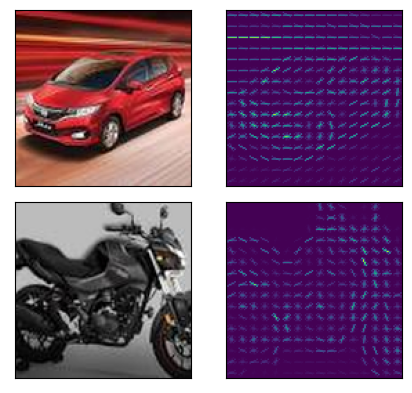

In [155]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

ax[0, 0].imshow(df_hog_128['pil_img'][0])
ax[0, 1].imshow(df_hog_128['hog_img'][0])
ax[1, 0].imshow(df_hog_128['pil_img'][2000])
ax[1, 1].imshow(df_hog_128['hog_img'][2000])

# remove tick labels
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])

fig.subplots_adjust(hspace=0)

plt.show()

In [101]:
svm_hog_128.fit(hog_wide_X, hog_y)

SVC(C=1, kernel='linear')

In [102]:
svm_hog_128.coef_.shape

(1, 16384)

In [138]:
def create_explainable_hog(df_hog, img_scale, weights, threshold, index):
    threshold = np.percentile(weights, 90)
    high_weight_mask = weights > threshold
    filtered_weights = np.where(high_weight_mask, weights, 0).reshape(-1)
    
    ex_img = df_hog['hog_img'][index].flatten()

    for i in range(len(ex_img)):
        if filtered_weights[i] == 0:
            ex_img[i] = 0
    
    return ex_img.reshape(img_scale, img_scale)

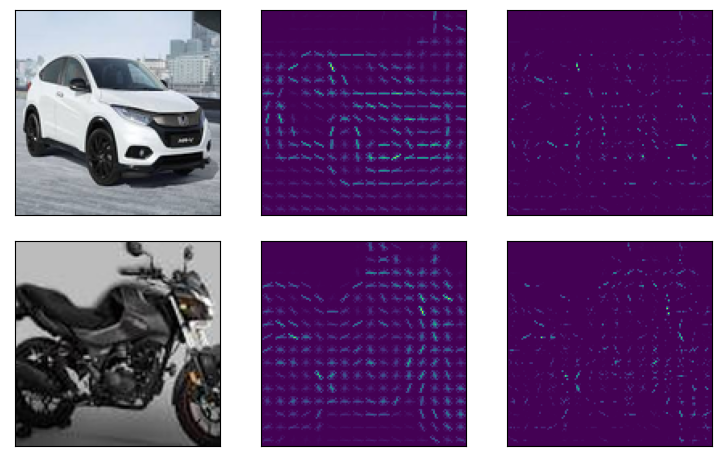

In [159]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

ax[0, 0].imshow(df_hog_128['pil_img'][3])
ax[0, 1].imshow(df_hog_128['hog_img'][3])
ax[0, 2].imshow(create_explainable_hog(df_hog_128, 128, svm_hog_128.coef_, 0.95, 3))
ax[1, 0].imshow(df_hog_128['pil_img'][2000])
ax[1, 1].imshow(df_hog_128['hog_img'][2000])
ax[1, 2].imshow(create_explainable_hog(df_hog_128, 128, svm_hog_128.coef_, 0.95, 2000))

# remove tick labels
for i in range(2):
    for j in range(3):
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])


fig.subplots_adjust(hspace=0)
plt.show()